In [1]:
%load_ext autoreload
%autoreload 2

In [175]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical

In [3]:
CLASSES = 2
REGRESSIONS = 5

In [4]:
tf.enable_eager_execution()

In [5]:
def read_data(serialized_example):
    # read TF records data format
    features = tf.parse_single_example(
            serialized=serialized_example,
            features={
                'img_name': tf.FixedLenFeature([], tf.string),
                'img_height': tf.FixedLenFeature([], tf.int64),
                'img_width': tf.FixedLenFeature([], tf.int64),
                'img': tf.FixedLenFeature([], tf.string),
                'gtboxes_and_label': tf.FixedLenFeature([], tf.string),
                'num_objects': tf.FixedLenFeature([], tf.int64)
            }
        )
    img_name = features['img_name']
    img_height = tf.cast(features['img_height'], tf.int32)
    img_width = tf.cast(features['img_width'], tf.int32)
    img = tf.decode_raw(features['img'], tf.uint8)
    
    img = tf.reshape(img, shape=[img_height, img_width, 3])
    
    gtboxes_and_label = tf.decode_raw(features['gtboxes_and_label'], tf.int32)
    gtboxes_and_label = tf.reshape(gtboxes_and_label, [-1, 9])
    
    num_objects = tf.cast(features['num_objects'], tf.int32)
    return img, gtboxes_and_label

10


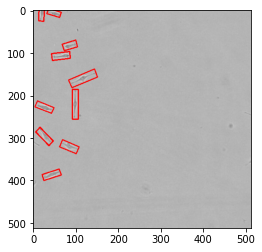

In [271]:
tfrecords_path = '/datasets/tfrecord/UFRGS_CELL_train'
dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecords_path+'*.tfrecord'))
dataset = dataset.map(read_data)
#dataset = dataset.map(adjust_data)
#dataset = dataset.batch(1)
#dataset = dataset.repeat()

for sample in dataset.take(10):
    pass

draw = np.copy(sample[0])
label = [lb[:-1].reshape(-1,2) for lb in sample[1].numpy()]
print(len(label))

cv2.drawContours(draw, label, -1, (255,0,0), 2)

plt.imshow(draw)

In [316]:
def get_gt(class_centers, regres_centers, reduce=16):

    # placeholder for placing the centers
    shape = class_centers.shape[0]//reduce, class_centers.shape[1]//reduce
    gt_regression = np.zeros(shape=(shape[0], shape[1], REGRESSIONS))
    gt_classification = np.zeros(shape=(shape[0], shape[1], CLASSES))

    # first map all unique center points and save the conflits
    conflits = []
    for gh,h in enumerate(range(reduce//2, class_centers.shape[0]-reduce//2, reduce)):
        for gw,w in enumerate(range(reduce//2, class_centers.shape[1]-reduce//2, reduce)):
            # get the label patch
            classes = class_centers[h-reduce//2:h+reduce//2, w-reduce//2:w+reduce//2]

            # get the number of center points
            nbr_centers = np.count_nonzero(classes)

            if nbr_centers==1:
                # get regression values
                regression = regres_centers[h-reduce//2:h+reduce//2, w-reduce//2:w+reduce//2]
                regression = np.sum(regression, axis=(0,1))

                # adjust cx and cy
                regression[0] -= gw*reduce
                regression[1] -= gh*reduce
                
                gt_regression[gh,gw] = regression
                
                # get the class value
                gt_classification[gh,gw,np.sum(classes)-1] = 1

            if nbr_centers>1:
                conflits.append([[gh,gw], [h,w]])
    
    # iterate over patches with conflits
    for (gh,gw), (h,w) in conflits:
        # get the conflit points in the patch
        classes = class_centers[h-reduce//2:h+reduce//2, w-reduce//2:w+reduce//2]
        regression = regres_centers[h-reduce//2:h+reduce//2, w-reduce//2:w+reduce//2]

        # get point of label
        cnt_pts = np.where(classes>0)
        cnt_pts = [[cnt_pts[0][i],cnt_pts[1][i]] for i in range(len(cnt_pts))]

        # calculate the distance to the borders
        dleft, dright, dtop, dbottom = [],[],[],[]
        for pt in cnt_pts:
            dleft.append(pt[1])
            dright.append(gt_regression.shape[0]-pt[0])
            dtop.append(pt[0])
            dbottom.append(gt_regression.shape[1]-pt[1])

        # calculate the distance to the center and sort related to how close they are to the center
        cnt_dist = [np.square((p[0]-reduce/2.)**2. + (p[1]-reduce/2.)**2.) for p in cnt_pts]
        arg_pts = np.argsort(cnt_dist, kind='mergesort')

        # get the regression values
        regression = [regression[pt[0],pt[1]] for p in cnt_pts]
        classes = [classes[pt[0],pt[1]] for p in cnt_pts]

        # now fill the gaps related to the conflits
        for i in arg_pts:
            # verify the best displacement
            extreme = np.array([dleft[i], dright[i], dtop[i], dbottom[i]])
            extreme = np.argsort(extreme, kind='mergesort')

            # try to fit in the sorted best direction
            found = False
            ww,hh = 0,0
            for k in range(gt_regression.shape[0]):
                for disp in extreme:
                    if disp==0: # left
                        if np.sum(gt_regression[gh, gw-k])==0 and gw-k>0:
                            ww = -k
                            found = True
                    elif disp==1: # right
                        if gw+k<gt_regression.shape[1] and np.sum(gt_regression[gh, gw+k])==0:
                            ww = k
                            found = True
                    elif disp==2: # top
                        if np.sum(gt_regression[gh-k, gw])==0 and gh-k>0:
                            hh = -k
                            found = True
                    else: # bottom
                        if gh+k<gt_regression.shape[0] and np.sum(gt_regression[gh+k, gw])==0:
                            hh = k
                            found = True
                    if found:
                        # adjust center values and store to annotations
                        regression[i][0] -= (gw+ww)*reduce
                        regression[i][1] -= (gh+hh)*reduce
                        
                        gt_regression[gh+hh, gw+ww] = regression[i]
                        gt_classification[gh+hh, gw+ww, classes[i]-1] = 1
                        break
                if found:
                    break
                    
    return gt_regression, gt_classification

In [317]:
def adjust_data(img, labels):
    # norm image
    img = tf.cast(img, 'float32')/127.5 - 1
    
    # add annotations to the center values of each class
    centers_regres = np.zeros(shape=(*img.shape[:2],REGRESSIONS), dtype='int32')
    centers_class = np.zeros(shape=img.shape[:2], dtype='int32')
    for lb in labels:
        # get boxes values
        box = lb[:-1].reshape(-1,2)
        (cx,cy), (w,h), angle= cv2.minAreaRect(box)

        # if center already has values, raise error
        if np.sum(centers_class[int(cy),int(cx)])>1:
            raise Exception()

        centers_regres[int(cy),int(cx)] = [cx,cy,w,h,angle]
        centers_class[int(cy),int(cx)] = lb[-1]+1
    
    centers_regres, centers_class = get_gt(centers_class, centers_regres)
    
    return img, centers_regres.astype('float32'), centers_class.astype('float32')

In [318]:
@tf.function(input_signature=[tf.TensorSpec((None,None,3), tf.uint8), tf.TensorSpec((None,9), tf.int32)])
def tf_adjust_data(img, label):
    return tf.py_func(adjust_data, [img, label], [tf.float32, tf.float32, tf.float32])

# adjust to feed network
def adjust2net(img, regress, classes):
    return {'input':img,
            'regression':regress,
            'classification':classes}

In [337]:
dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecords_path+'*.tfrecord'))
dataset = dataset.map(read_data)
dataset = dataset.map(tf_adjust_data)
dataset = dataset.map(adjust2net)
#dataset = dataset.batch(1)
dataset = dataset.repeat()

for sample in dataset.take(5):
    pass

draw = np.copy(sample['input'])
classes = np.copy(sample['classification'])
regression = np.copy(sample['regression'])

In [338]:
draw.shape, classes.shape, regression.shape

((512, 512, 3), (32, 32, 2), (32, 32, 5))

In [339]:
def view_data(img, classes, regression, reduce=16):
    
    count = 0
    
    draw = np.copy(img)
    colors = [(255,0,0), (0,255,0)]
    
    for cl in range(CLASSES):
        cnt = classes[...,cl]
        
        for gh in range(cnt.shape[0]):
            for gw in range(cnt.shape[1]):
                if cnt[gh,gw]==0:
                    continue
                
                reg = regression[gh,gw]
                reg[0] += gw*reduce
                reg[1] += gh*reduce
                
                rect = ((reg[0],reg[1]), (reg[2],reg[3]), reg[4])
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                cv2.drawContours(draw, [box], -1, colors[cl], 2)
                count +=1
    
    plt.figure(figsize=(10,10))
    plt.imshow(draw)

In [340]:
np.count_nonzero(classes)

5

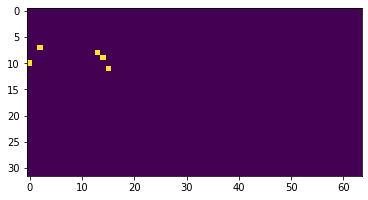

In [341]:
plt.imshow(np.hstack([classes[...,0], classes[...,1]]))

5


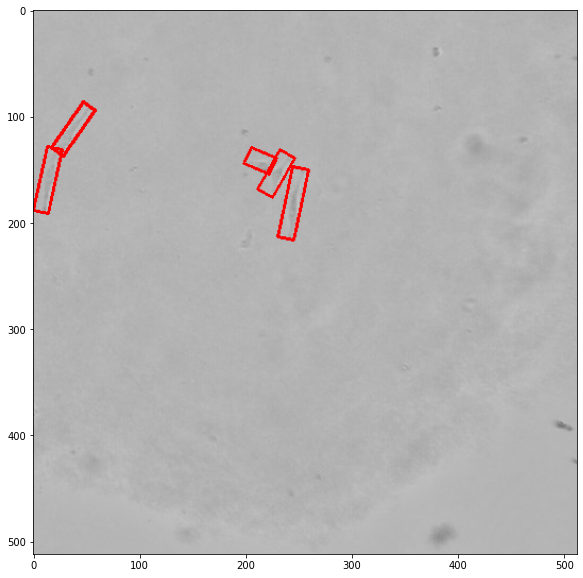

In [342]:
view_data(np.uint8((draw+1)*127.5), classes, regression)